In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
import cv2
from sklearn.metrics import pairwise_distances
import shutil
import time, datetime
import pandas as pd

import PIL.Image as Image
from matplotlib import cm

In [2]:
base_dir = './data/moth-FLIR-viz-cold'
SEQs = [f for f in os.listdir(base_dir) if f.endswith('.SEQ')]

FW_chars = []
for n in SEQs:
    
    print(n)

    thermal_video_dir = f'{base_dir}/{n}'
    thermal_npy_dir = f'{thermal_video_dir}/npy'
    thermal_temps_dir = './data/moth-FLIR-temps-cold/'
    
    # Rename npy files
    thermal_files_ = np.sort([f for f in os.listdir(thermal_npy_dir) if f.endswith('.npy')])
    thermal_files = []
    for f in thermal_files_:
        f_ = f.replace('_0800.npy', '')
        len_diff = 23 - len(f_)
        if len_diff > 0:
            f_new = f_ + '_000'[(4-len_diff):] + '_0800.npy'
            #print(f, f_new)
            shutil.move(f'{thermal_npy_dir}/{f}', f'{thermal_npy_dir}/{f_new}')
        else:
            f_new = f
        thermal_files.append(f_new)

    thermal_files = np.sort(thermal_files)

    # Get global temp info
    global_min = np.inf
    global_max = -np.inf

    for i in range(len(thermal_files)):
        print(i, end='\r')
        tempMat = np.load(f'{thermal_npy_dir}/{thermal_files[i]}')
        global_min = min(tempMat.min(), global_min)
        global_max = max(tempMat.max(), global_max)


    # output thermal videos
    thermal_fps = 1
    thermal_fps = 1
    fast_forward = 1
    out_global = cv2.VideoWriter(f'{thermal_video_dir}/global_{n}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), thermal_fps * fast_forward, (tempMat.shape[0], tempMat.shape[1]))
    #out_local = cv2.VideoWriter(f'{thermal_video_dir}/local_{n}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), thermal_fps * fast_forward, (tempMat.shape[0], tempMat.shape[1]))
    for i in range(len(thermal_files)):
        print(i, end='\r')
        tempMat = np.load(f'{thermal_npy_dir}/{thermal_files[i]}').T
        #tempImg_local = (tempMat - tempMat.min()) / (tempMat.max() - tempMat.min())
        tempImg_global = (tempMat - global_min) / (global_max - global_min)
        #io.imsave((save_dir + thermal_files[i]).replace('.npy', '.jpg'), tempImg)
        tempImg_global = (tempImg_global * 255).astype(np.uint8)
        #tempImg_local = (tempImg_local * 255).astype(np.uint8)
        out_global.write(np.stack([tempImg_global,tempImg_global,tempImg_global]).transpose(1,2,0))
        #out_local.write(np.stack([tempImg_local,tempImg_local,tempImg_local]).transpose(1,2,0))
    out_global.release() 
    #out_local.release() 

    # arbitrary rescaled i for background removing (making mask) from the video
    #i = 3
    #tempMat = np.load(f'{thermal_npy_dir}/{thermal_files[i]}').T
    #tempImg = (tempMat - global_min) / (global_max - global_min)
    #tempImg = (tempMat - tempMat.min()) / (tempMat.max() - tempMat.min())
    #tempImg = (tempImg * 255).astype(np.uint8)
    # plt.imshow(tempImg)
    thermal_mask_dir = './data/moth-FLIR-mask-cold/mask'
    #io.imsave(f'{thermal_mask_dir}/{n}.bmp', tempImg)

    # read masks, the backgrounds in the file are set to 255 by default
    # re-set Foreground to 1, background to 0
    fw_mask_ = cv2.imread(f'{thermal_mask_dir}/{n[:-4]}_FW.SEQ.bmp', cv2.IMREAD_GRAYSCALE)
    fw_mask = np.where(fw_mask_==255, 0, 1)
    fw_mask = np.where(fw_mask==0, np.nan, 1)

    fw_masked = 1
    if fw_mask_ is None:
        fw_masked = 0

    if fw_masked == 0:
        print('no', f'{thermal_mask_dir}/{n[:-4]}_FW.SEQ.bmp')
        
    if fw_masked == 1:
        print('OK')
        
    # Analysis for fore wings only, add hindwing and all wings if neccesary
    # if no mask is used, then there will be no different among forewings, hindwings and whole specimen
    t_streams = []
    for i in range(len(thermal_files)):
        print(i, end='\r')
        tempMat = np.load(f'{thermal_npy_dir}/{thermal_files[i]}').T
        fw_temps = tempMat * fw_mask
        
        # value clipping
        # remove extreme values
        # plt.hist(fw_temps.reshape(-1))
        orig_q975 = np.nanquantile(fw_temps, .975)
        orig_q025 = np.nanquantile(fw_temps, .025)
        fw_temps[fw_temps > orig_q975] = orig_q975 #np.nan
        fw_temps[fw_temps < orig_q025] = orig_q025 #np.nan

        t_min = np.nanmin(fw_temps)
        t_max = np.nanmax(fw_temps)
        t_q25 = np.nanquantile(fw_temps, .25)
        t_q50 = np.nanquantile(fw_temps, .50)
        t_q75 = np.nanquantile(fw_temps, .75)
        t_avg = np.nanmean(fw_temps)
        t_std = np.nanstd(fw_temps)
        t_streams.append({'min':t_min, 'q25':t_q25, 'q50':t_q50, 'q75':t_q75, 'max':t_max, 'avg':t_avg, 'std':t_std, 
                         'fw_masked': fw_masked})
        # break

    t_streams_df = pd.DataFrame(t_streams)
    t_streams_df.to_csv(f'{thermal_temps_dir}/FW/csv/{n}_FW.csv', sep='\t', index=False)


    # heating from
    target_t = 'avg'
    t_avg_start = t_streams_df.iloc[:3][target_t].min()
    # Temp diff
    t_avg_diff = t_streams_df.iloc[32][target_t] - t_streams_df.iloc[2][target_t]
    
    target_t = 'q50'
    t_q50_start = t_streams_df.iloc[:3][target_t].min()
    # Temp diff
    t_q50_diff = t_streams_df.iloc[32][target_t] - t_streams_df.iloc[2][target_t]

    # cooling
    # target: the time frame where the t_q50 decrease half of the increasement
    cond_satisfied_idx = np.where(t_streams_df[target_t] < t_streams_df.iloc[32][target_t] - t_q50_diff/2)[0]
    satisfied_idx = cond_satisfied_idx[np.where(cond_satisfied_idx > 32)[0].min()]

    # Plot
    fig = plt.figure(figsize=(20,10))
    plt.plot(t_streams_df[['min', 'q25', 'q50','avg', 'q75', 'max']])
    plt.axvline(2, color='red')
    plt.axvline(32, color='blue')
    plt.axvline(satisfied_idx, color='green')
    plt.savefig(f'{thermal_temps_dir}/FW/jpg/{n}_FW.jpg')
    plt.title(f'{n}_FW')
    plt.close()
    
    FW_chars.append({'fname':f'{n}', 
                     'avg_start':t_q50_start, 
                     'avg_diff':t_avg_diff,
                     'q50_diff':t_q50_diff,
                     'avg_end':t_streams_df.iloc[32][target_t], 
                     'cooling_target':t_streams_df.iloc[32][target_t] - t_q50_diff/2,
                     'avg_satisfied':t_streams_df.iloc[satisfied_idx][target_t], 
                     'satisfied_idx':satisfied_idx, 'cooling_time': satisfied_idx-32})

sd-female-alt1-model-1.SEQ
OK3
sd-male-alt1-model-3.SEQ
OK3
sm-male-alt5-model-2.SEQ
OK2
sm-male-alt5-model-3.SEQ
OK3
sd-male-alt1-model-2.SEQ
OK3
sd-female-alt1-model-2.SEQ
OK3
sm-male-alt5-model-1.SEQ
OK3
sd-male-alt1-model-1.SEQ
OK3
sd-female-alt1-model-3.SEQ
OK7
sm-male-alt0-model-1.SEQ
OK2
sd-female-alt4-model-2.SEQ
OK5
sm-female-alt0-control_D-2.SEQ
OK3
sm-female-alt0-control_D-3.SEQ
OK3
sd-female-alt4-model-3.SEQ
OK3
sm-female-alt3-model-1.SEQ
OK2
sd-female-alt0-control_L-1.SEQ
OK3
sd-male-alt4-model-1.SEQ
OK3
sd-male-alt4-model-3.SEQ
OK3
sm-male-alt0-model-2.SEQ
OK3
sd-female-alt0-control_L-3.SEQ
OK3
sm-female-alt3-model-3.SEQ
OK6
sm-female-alt0-control_D-1.SEQ
OK3
sd-female-alt4-model-1.SEQ
OK3
sm-female-alt3-model-2.SEQ
OK2
sd-female-alt0-control_L-2.SEQ
OK3
sm-male-alt0-model-3.SEQ
OK3
sd-male-alt4-model-2.SEQ
OK3
sd-male-alt0-control_D-1.SEQ
OK3
sm-male-alt3-model-3.SEQ
OK2
sm-female-alt0-model-2.SEQ
OK3
sm-female-alt0-model-3.SEQ
OK3
sm-male-alt3-model-2.SEQ
OK3
sd-male-al

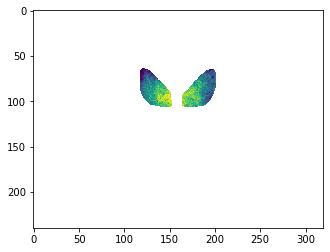

In [3]:
plt.imshow(fw_temps)

In [5]:
pd.DataFrame(FW_chars).to_csv('./thermal_plot_me_with_metadata_cold_FW.csv', index=False, sep='\t')